In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Database path
DB_PATH = Path("medallion.db")

In [5]:
def query_db(sql, db_path=DB_PATH):
    """Helper function to query the database and return a DataFrame"""
    with sqlite3.connect(db_path) as conn:
        return pd.read_sql_query(sql, conn)

def show_table_info(table_name):
    """Display basic info about a table"""
    df = query_db(f"SELECT * FROM {table_name} LIMIT 5")
    print(f"\n{'='*60}")
    print(f"Table: {table_name}")
    print(f"{'='*60}")
    print(f"Shape: {query_db(f'SELECT COUNT(*) as count FROM {table_name}').iloc[0]['count']} rows")
    print(f"Columns: {', '.join(df.columns)}")
    print(f"\nFirst 5 rows:")
    display(df)
    return df

In [6]:
bronze_item = show_table_info('bronze_item')


Table: bronze_item
Shape: 2198 rows
Columns: adjective, category, created_at, id, modifier, name, price

First 5 rows:


,adjective,category,created_at,id,modifier,name,price
0,fuzzy,contraption,2014-01-15 21:36:09,2512.0,carrying_case,fuzzy contraption carrying_case,150.0
1,None,instrument,2013-05-14 05:20:50,482.0,refill,instrument refill,35.2
2,industrial-strength,module,2014-02-04 19:28:32,2446.0,None,industrial-strength module,300.0
3,digital,tool,2013-02-25 12:23:18,1312.0,carrying_case,digital tool carrying_case,16.5
4,miniature,device,2013-08-05 17:20:45,3556.0,cleaner,miniature device cleaner,16.5


In [7]:
# Check data types and missing values
print("\nData Quality Check:")
print(f"Total rows: {len(bronze_item)}")
print(f"\nMissing values:")
print(bronze_item.isnull().sum())


Data Quality Check:
Total rows: 5

Missing values:
adjective     1
category      0
created_at    0
id            0
modifier      1
name          0
price         0
dtype: int64


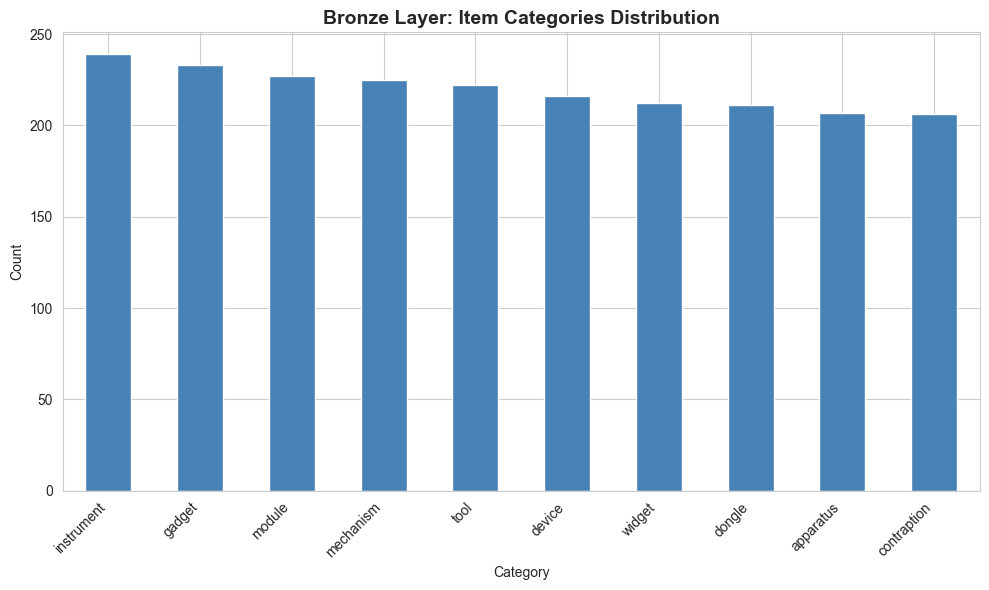

In [8]:
# Category distribution
bronze_item_full = query_db("SELECT * FROM bronze_item")
category_dist = bronze_item_full['category'].value_counts()

plt.figure(figsize=(10, 6))
category_dist.plot(kind='bar', color='steelblue')
plt.title('Bronze Layer: Item Categories Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
print(f"\nTotal categories: {len(category_dist)}")
print(f"\nTop 10 categories:")
print(category_dist.head(10))


Total categories: 10

Top 10 categories:
category
instrument     239
gadget         233
module         227
mechanism      225
tool           222
device         216
widget         212
dongle         211
apparatus      207
contraption    206
Name: count, dtype: int64


In [10]:
bronze_event = show_table_info('bronze_event')


Table: bronze_event
Shape: 853640 rows
Columns: event_id, event_time, user_id, event_payload

First 5 rows:


,event_id,event_time,user_id,event_payload
0,b9de71c5c3cc4cd7a97e50b832106e5a,2017-06-26 11:23:39,178481.0,"{""event_name"":""view_item"",""platform"":""android""..."
1,23267713c9ea44419331731f50b6a8db,2017-06-27 10:46:39,178481.0,"{""event_name"":""view_item"",""platform"":""android""..."
2,1b7822fa7b854e01970218ae8f721fe0,2017-06-27 11:15:39,178481.0,"{""event_name"":""view_item"",""platform"":""android""..."
3,2a7a188a626841ac94befcc419f06af4,2016-10-05 20:43:10,154133.0,"{""event_name"":""view_item"",""platform"":""android""..."
4,631d657264cc4616a4528f759509b25d,2016-10-04 03:29:10,154133.0,"{""event_name"":""view_item"",""platform"":""android""..."


In [11]:
# Parse event payload to understand structure
print("\nSample event payload structures:")
for i in range(min(3, len(bronze_event))):
    payload = json.loads(bronze_event.iloc[i]['event_payload'])
    print(f"\nEvent {i+1}:")
    print(json.dumps(payload, indent=2))


Sample event payload structures:

Event 1:
{
  "event_name": "view_item",
  "platform": "android",
  "parameter_name": "item_id",
  "parameter_value": "3526"
}

Event 2:
{
  "event_name": "view_item",
  "platform": "android",
  "parameter_name": "item_id",
  "parameter_value": "1514"
}

Event 3:
{
  "event_name": "view_item",
  "platform": "android",
  "parameter_name": "item_id",
  "parameter_value": "3712"
}


In [12]:
# Event statistics
bronze_event_full = query_db("SELECT * FROM bronze_event")
print(f"\nTotal events: {len(bronze_event_full)}")
print(f"Unique users: {bronze_event_full['user_id'].nunique()}")
print(f"Unique events: {bronze_event_full['event_id'].nunique()}")


Total events: 853640
Unique users: 109624
Unique events: 428364


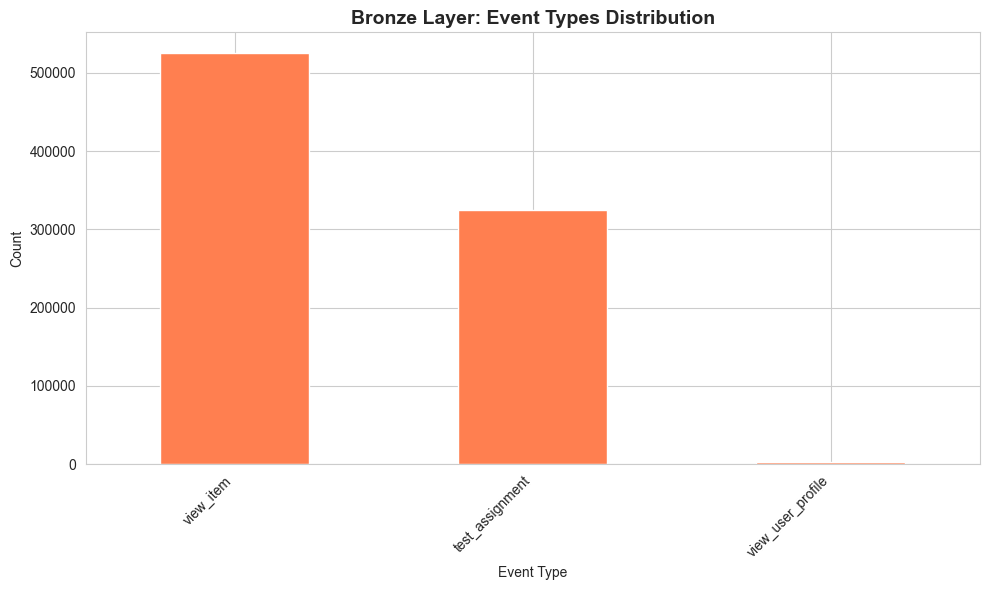


Event type breakdown:
view_item            525572
test_assignment      324980
view_user_profile      3088
Name: count, dtype: int64


In [13]:
# Parse all payloads to get event types
event_types = []
for payload_str in bronze_event_full['event_payload']:
    try:
        payload = json.loads(payload_str)
        event_types.append(payload.get('event_name', 'unknown'))
    except:
        event_types.append('parse_error')

event_type_dist = pd.Series(event_types).value_counts()

plt.figure(figsize=(10, 6))
event_type_dist.plot(kind='bar', color='coral')
plt.title('Bronze Layer: Event Types Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nEvent type breakdown:")
print(event_type_dist)

In [14]:
silver_item = show_table_info('silver_item')


Table: silver_item
Shape: 2198 rows
Columns: item_id, item_name, category, adjective, modifier, price, created_at_ts

First 5 rows:


,item_id,item_name,category,adjective,modifier,price,created_at_ts
0,2512,fuzzy contraption carrying_case,contraption,fuzzy,carrying_case,150.0,2014-01-15 21:36:09
1,482,instrument refill,instrument,unknown,refill,35.2,2013-05-14 05:20:50
2,2446,industrial-strength module,module,industrial-strength,unknown,300.0,2014-02-04 19:28:32
3,1312,digital tool carrying_case,tool,digital,carrying_case,16.5,2013-02-25 12:23:18
4,3556,miniature device cleaner,device,miniature,cleaner,16.5,2013-08-05 17:20:45


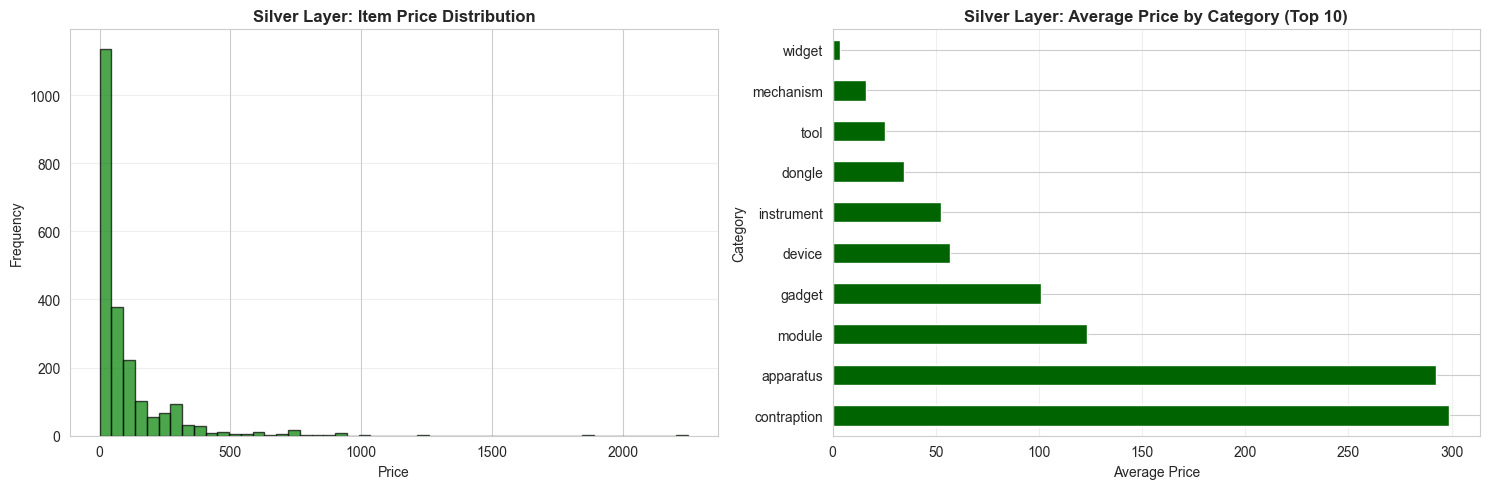


Price statistics:
count    2198.000000
mean       98.157420
std       156.059937
min         0.000000
25%        13.750000
50%        42.000000
75%       115.700000
max      2250.000000
Name: price, dtype: float64


In [26]:
# Price analysis
silver_item_full = query_db("SELECT * FROM silver_item")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Price distribution
axes[0].hist(silver_item_full['price'].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title('Silver Layer: Item Price Distribution', fontweight='bold')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# Price by category (top 10)
price_by_category = silver_item_full.groupby('category')['price'].mean().sort_values(ascending=False).head(10)
price_by_category.plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Silver Layer: Average Price by Category (Top 10)', fontweight='bold')
axes[1].set_xlabel('Average Price')
axes[1].set_ylabel('Category')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPrice statistics:")
print(silver_item_full['price'].describe())

In [18]:
print("\nTop adjectives:")
print(silver_item_full['adjective'].value_counts().head(10))

print("\nTop modifiers:")
print(silver_item_full['modifier'].value_counts().head(10))


Top adjectives:
adjective
unknown                272
reflective             168
industrial-strength    164
fuzzy                  153
prize-winning          153
rechargable            153
aerodynamic            153
extra-strength         153
analog                 148
matte                  142
Name: count, dtype: int64

Top modifiers:
modifier
unknown          766
storage_unit     186
charger          172
opener           169
refill           162
wrapper          158
how-to-manual    156
cleaner          146
carrying_case    144
warmer           139
Name: count, dtype: int64


In [19]:
silver_event = show_table_info('silver_event')


Table: silver_event
Shape: 853640 rows
Columns: event_id, event_at_ts, user_id, event_name, platform, parameter_name, parameter_value, event_year

First 5 rows:


,event_id,event_at_ts,user_id,event_name,platform,parameter_name,parameter_value,event_year
0,b9de71c5c3cc4cd7a97e50b832106e5a,2017-06-26 11:23:39,178481,view_item,android,item_id,3526,2017
1,23267713c9ea44419331731f50b6a8db,2017-06-27 10:46:39,178481,view_item,android,item_id,1514,2017
2,1b7822fa7b854e01970218ae8f721fe0,2017-06-27 11:15:39,178481,view_item,android,item_id,3712,2017
3,2a7a188a626841ac94befcc419f06af4,2016-10-05 20:43:10,154133,view_item,android,item_id,3586,2016
4,631d657264cc4616a4528f759509b25d,2016-10-04 03:29:10,154133,view_item,android,item_id,1061,2016


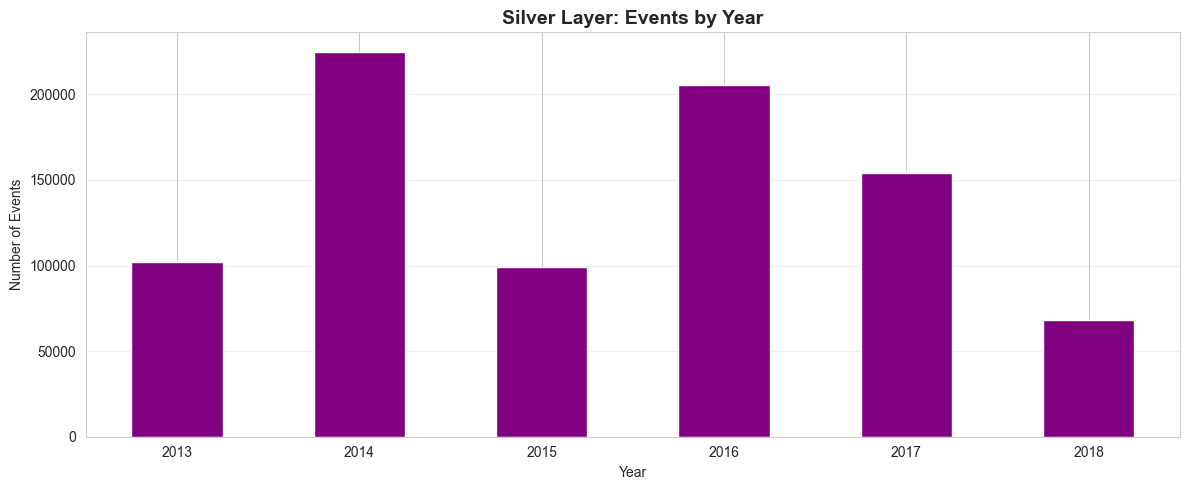


Events per year:
event_year
2013    101838
2014    224996
2015     99221
2016    205233
2017    153930
2018     68422
Name: count, dtype: int64


In [25]:
# Event analysis over time
silver_event_full = query_db("SELECT * FROM silver_event")
silver_event_full['event_at_ts'] = pd.to_datetime(silver_event_full['event_at_ts'])

# Events by year
events_by_year = silver_event_full['event_year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
events_by_year.plot(kind='bar', color='purple')
plt.title('Silver Layer: Events by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEvents per year:")
print(events_by_year)

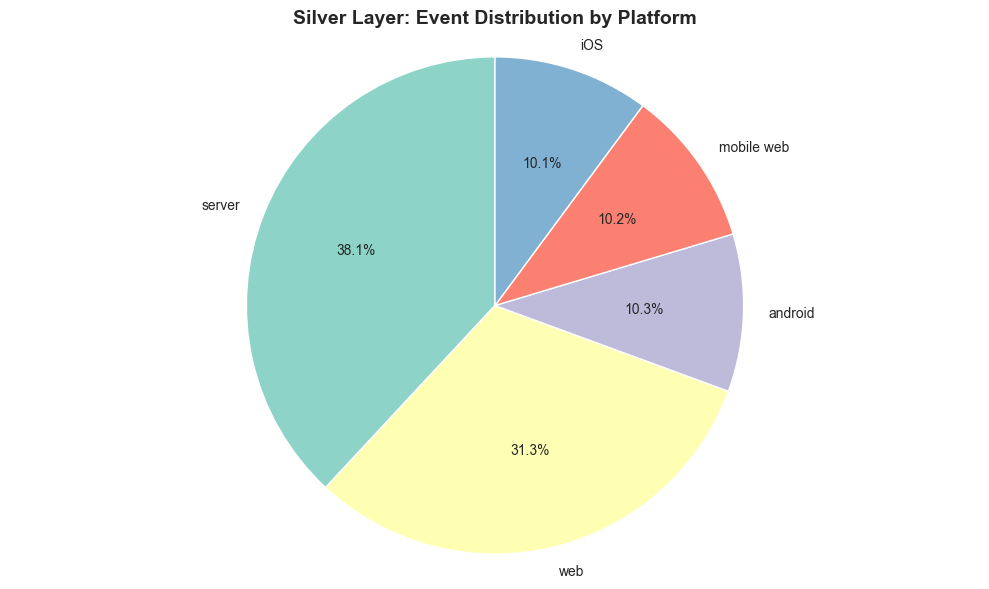


Platform breakdown:
platform
server        324980
web           267421
android        87501
mobile web     87224
iOS            86514
Name: count, dtype: int64


In [22]:
# Platform analysis
platform_dist = silver_event_full['platform'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(platform_dist.values, labels=platform_dist.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('Set3'))
plt.title('Silver Layer: Event Distribution by Platform', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\nPlatform breakdown:")
print(platform_dist)

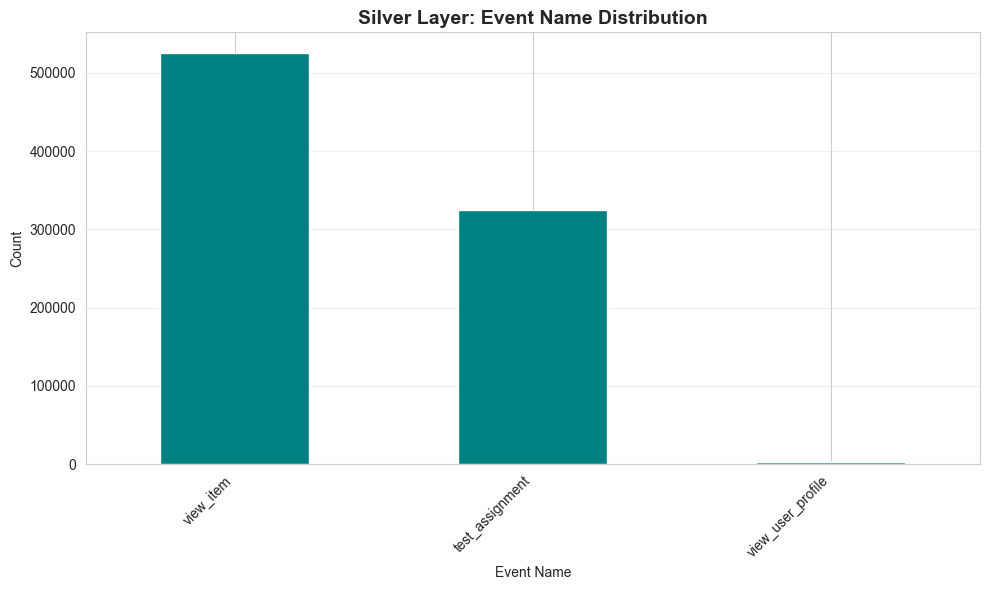


Event name breakdown:
event_name
view_item            525572
test_assignment      324980
view_user_profile      3088
Name: count, dtype: int64


In [23]:
# Event name distribution
event_name_dist = silver_event_full['event_name'].value_counts()

plt.figure(figsize=(10, 6))
event_name_dist.plot(kind='bar', color='teal')
plt.title('Silver Layer: Event Name Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Event Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEvent name breakdown:")
print(event_name_dist)

In [27]:
gold_top_item = show_table_info('gold_top_item')


Table: gold_top_item
Shape: 13093 rows
Columns: item_id, item_name, category, event_year, total_views, item_rank_in_year, most_used_platform

First 5 rows:


,item_id,item_name,category,event_year,total_views,item_rank_in_year,most_used_platform
0,2086,organic device,device,2013,12,1,web
1,3517,prize-winning widget wrapper,widget,2013,12,1,web
2,3063,fuzzy gadget wrapper,gadget,2013,11,3,web
3,3200,prize-winning widget refill,widget,2013,10,4,web
4,3309,industrial-strength dongle,dongle,2013,10,4,mobile web


In [37]:
gold_full = query_db("SELECT * FROM gold_top_item ORDER BY event_year, item_rank_in_year")

print(f"\nTotal items in gold layer: {len(gold_full)}")
print(f"Years covered: {sorted(gold_full['event_year'].unique())}")


Total items in gold layer: 13093
Years covered: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]


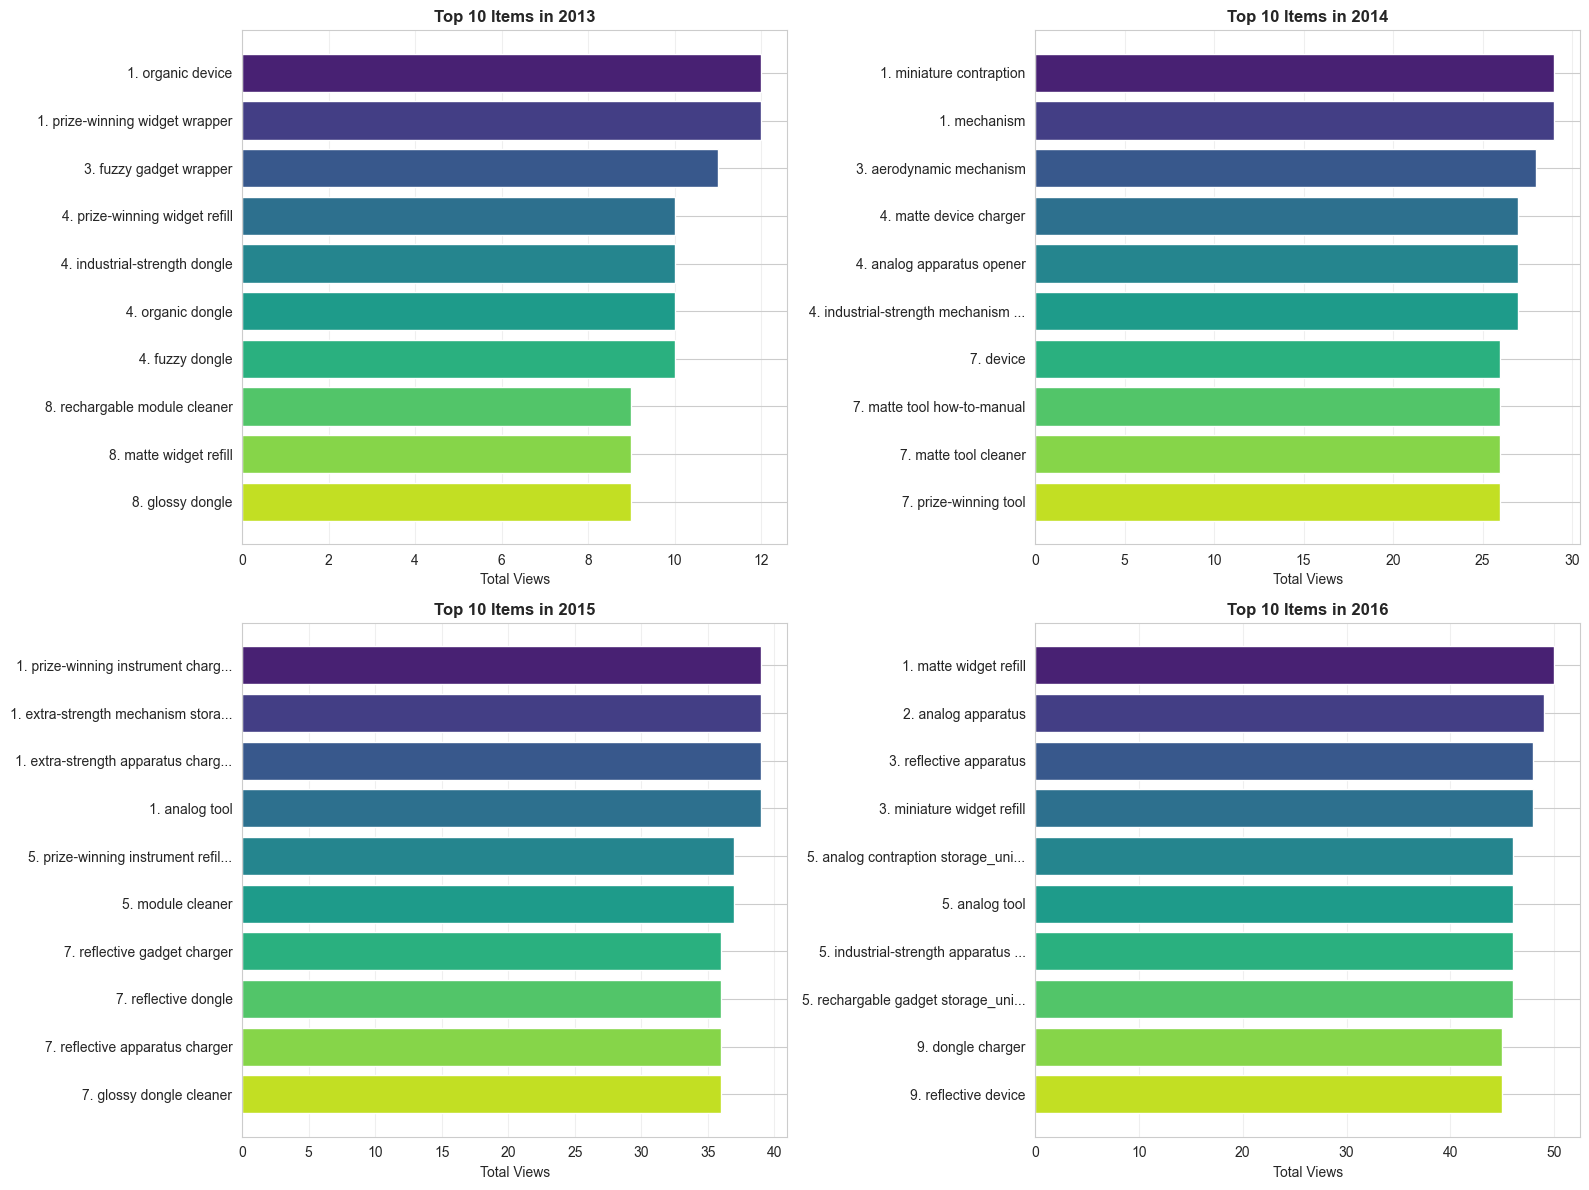

In [38]:
# Top 10 items by year
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
years = sorted(gold_full['event_year'].unique())

for idx, year in enumerate(years[:4]):  # Show first 4 years
    if idx >= 4:
        break
    
    row = idx // 2
    col = idx % 2
    
    year_data = gold_full[gold_full['event_year'] == year].head(10)
    
    axes[row, col].barh(range(len(year_data)), year_data['total_views'], 
                         color=sns.color_palette('viridis', len(year_data)))
    axes[row, col].set_yticks(range(len(year_data)))
    axes[row, col].set_yticklabels([f"{rank}. {name[:30]}..." if len(name) > 30 else f"{rank}. {name}" 
                                     for rank, name in zip(year_data['item_rank_in_year'], 
                                                          year_data['item_name'])])
    axes[row, col].set_xlabel('Total Views')
    axes[row, col].set_title(f'Top 10 Items in {year}', fontweight='bold')
    axes[row, col].grid(axis='x', alpha=0.3)
    axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()

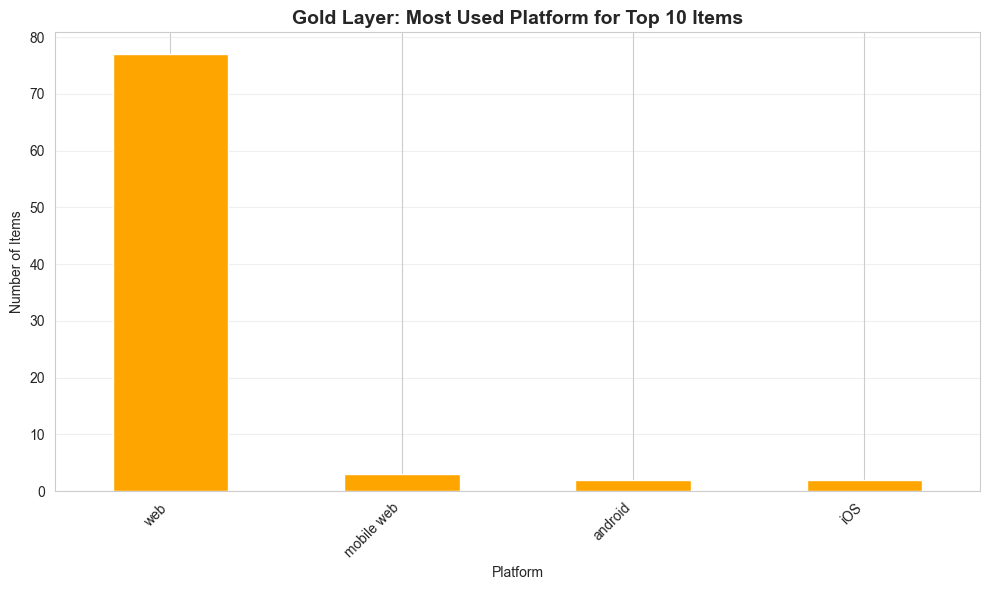


Platform preferences for top 10 items:
most_used_platform
web           77
mobile web     3
android        2
iOS            2
Name: count, dtype: int64


In [39]:
# Platform preferences for top items
top_items_by_year = gold_full[gold_full['item_rank_in_year'] <= 10]

platform_preference = top_items_by_year['most_used_platform'].value_counts()

plt.figure(figsize=(10, 6))
platform_preference.plot(kind='bar', color='orange')
plt.title('Gold Layer: Most Used Platform for Top 10 Items', fontsize=14, fontweight='bold')
plt.xlabel('Platform')
plt.ylabel('Number of Items')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nPlatform preferences for top 10 items:")
print(platform_preference)

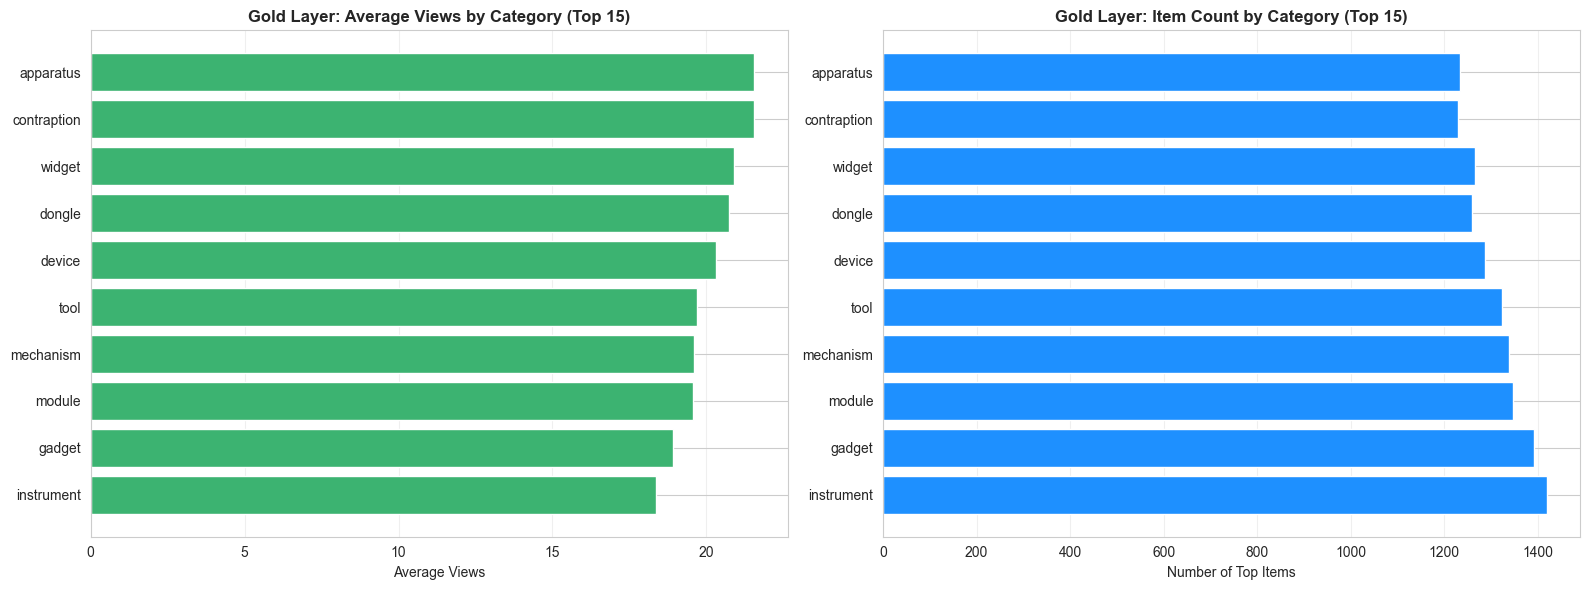

,category,item_count,avg_views,max_views,best_rank
0,apparatus,1234,21.555105,56,1
1,contraption,1229,21.532954,58,1
2,widget,1266,20.906003,53,1
3,dongle,1260,20.746825,51,4
4,device,1287,20.299145,57,1
5,tool,1323,19.708995,48,1
6,mechanism,1338,19.600897,49,1
7,module,1346,19.554235,52,2
8,gadget,1391,18.930266,49,3
9,instrument,1419,18.348837,46,1


In [40]:
# Category performance
category_performance = query_db("""
    SELECT 
        category,
        COUNT(*) as item_count,
        AVG(total_views) as avg_views,
        MAX(total_views) as max_views,
        MIN(item_rank_in_year) as best_rank
    FROM gold_top_item
    GROUP BY category
    ORDER BY avg_views DESC
    LIMIT 15
""")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average views by category
axes[0].barh(range(len(category_performance)), category_performance['avg_views'], 
             color='mediumseagreen')
axes[0].set_yticks(range(len(category_performance)))
axes[0].set_yticklabels(category_performance['category'])
axes[0].set_xlabel('Average Views')
axes[0].set_title('Gold Layer: Average Views by Category (Top 15)', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Item count by category
axes[1].barh(range(len(category_performance)), category_performance['item_count'], 
             color='dodgerblue')
axes[1].set_yticks(range(len(category_performance)))
axes[1].set_yticklabels(category_performance['category'])
axes[1].set_xlabel('Number of Top Items')
axes[1].set_title('Gold Layer: Item Count by Category (Top 15)', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

display(category_performance)

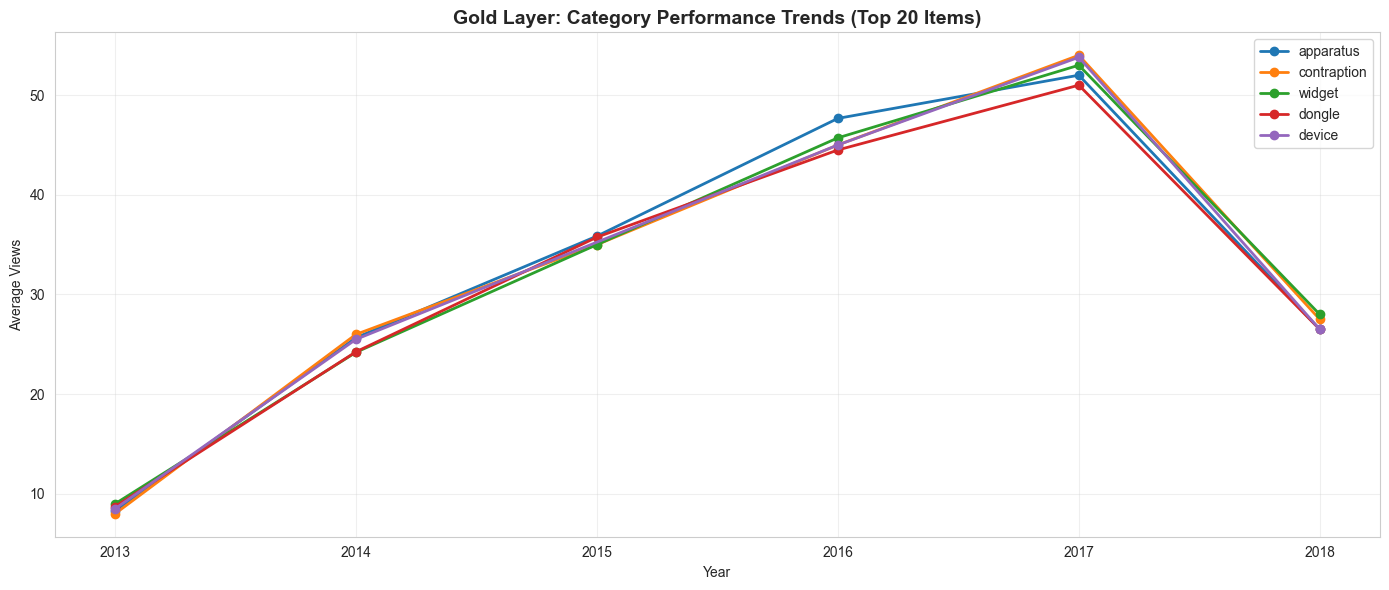

In [41]:
# Year-over-year trends for top categories
top_categories = category_performance.head(5)['category'].tolist()

category_trends = query_db(f"""
    SELECT 
        event_year,
        category,
        COUNT(*) as items_in_top_ranks,
        AVG(total_views) as avg_views
    FROM gold_top_item
    WHERE category IN ({','.join(['?' for _ in top_categories])})
    AND item_rank_in_year <= 20
    GROUP BY event_year, category
    ORDER BY event_year, category
""".replace('?', "'%s'") % tuple(top_categories))

plt.figure(figsize=(14, 6))
for category in top_categories:
    cat_data = category_trends[category_trends['category'] == category]
    plt.plot(cat_data['event_year'], cat_data['avg_views'], 
             marker='o', linewidth=2, label=category)

plt.title('Gold Layer: Category Performance Trends (Top 20 Items)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Average Views')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

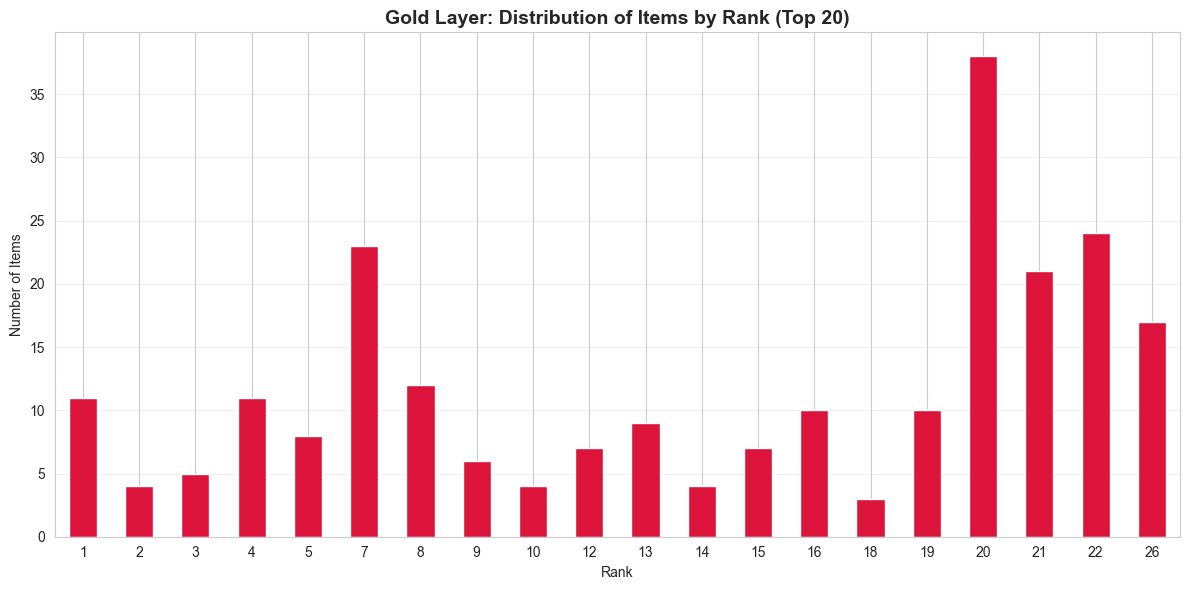

In [42]:
# Overall item rank distribution
rank_distribution = gold_full['item_rank_in_year'].value_counts().sort_index().head(20)

plt.figure(figsize=(12, 6))
rank_distribution.plot(kind='bar', color='crimson')
plt.title('Gold Layer: Distribution of Items by Rank (Top 20)', fontsize=14, fontweight='bold')
plt.xlabel('Rank')
plt.ylabel('Number of Items')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# Compare data quality across layers
print("\n" + "="*60)
print("DATA QUALITY SUMMARY ACROSS LAYERS")
print("="*60)

bronze_item_count = query_db("SELECT COUNT(*) as count FROM bronze_item").iloc[0]['count']
silver_item_count = query_db("SELECT COUNT(*) as count FROM silver_item").iloc[0]['count']

bronze_event_count = query_db("SELECT COUNT(*) as count FROM bronze_event").iloc[0]['count']
silver_event_count = query_db("SELECT COUNT(*) as count FROM silver_event").iloc[0]['count']

print(f"\nItem Pipeline:")
print(f"  Bronze → Silver: {bronze_item_count} → {silver_item_count} rows")
print(f"  Data retention: {silver_item_count/bronze_item_count*100:.1f}%")

print(f"\nEvent Pipeline:")
print(f"  Bronze → Silver: {bronze_event_count} → {silver_event_count} rows")
print(f"  Data retention: {silver_event_count/bronze_event_count*100:.1f}%")

gold_count = query_db("SELECT COUNT(*) as count FROM gold_top_item").iloc[0]['count']
print(f"\nGold Layer:")
print(f"  Total aggregated records: {gold_count}")


DATA QUALITY SUMMARY ACROSS LAYERS

Item Pipeline:
  Bronze → Silver: 2198 → 2198 rows
  Data retention: 100.0%

Event Pipeline:
  Bronze → Silver: 853640 → 853640 rows
  Data retention: 100.0%

Gold Layer:
  Total aggregated records: 13093


In [44]:
# End-to-end data lineage example: Track a specific item
print("\n" + "="*60)
print("END-TO-END DATA LINEAGE EXAMPLE")
print("="*60)

# Get a top item from gold
top_item = gold_full[gold_full['item_rank_in_year'] == 1].iloc[0]
item_id = top_item['item_id']

print(f"\nTracking Item ID: {item_id}")
print(f"Item Name: {top_item['item_name']}")
print(f"Category: {top_item['category']}")

# Bronze layer
bronze_record = query_db(f"SELECT * FROM bronze_item WHERE id = '{item_id}'")
print(f"\nBronze Layer (Raw):")
display(bronze_record)

# Silver layer
silver_record = query_db(f"SELECT * FROM silver_item WHERE item_id = {item_id}")
print(f"\nSilver Layer (Cleaned):")
display(silver_record)

# Gold layer
gold_records = query_db(f"SELECT * FROM gold_top_item WHERE item_id = {item_id} ORDER BY event_year")
print(f"\nGold Layer (Analytics):")
display(gold_records)


END-TO-END DATA LINEAGE EXAMPLE

Tracking Item ID: 2086
Item Name: organic device
Category: device

Bronze Layer (Raw):


,adjective,category,created_at,id,modifier,name,price



Silver Layer (Cleaned):


,item_id,item_name,category,adjective,modifier,price,created_at_ts
0,2086,organic device,device,organic,unknown,75,2013-07-17 18:43:28



Gold Layer (Analytics):


,item_id,item_name,category,event_year,total_views,item_rank_in_year,most_used_platform
0,2086,organic device,device,2013,12,1,web
1,2086,organic device,device,2014,21,91,web
2,2086,organic device,device,2015,26,441,web
3,2086,organic device,device,2016,32,566,web
4,2086,organic device,device,2017,26,2002,web
5,2086,organic device,device,2018,24,43,web


In [46]:
top_items_df = query_db(f"""
  SELECT * FROM gold_top_item
  WHERE event_year IS NOT NULL
  ORDER BY event_year DESC, item_rank_in_year ASC
  LIMIT 20
""")
display(top_items_df)

,item_id,item_name,category,event_year,total_views,item_rank_in_year,most_used_platform
0,597,widget opener,widget,2018,33,1,web
1,2422,glossy contraption,contraption,2018,29,2,web
2,3882,module,module,2018,29,2,web
3,159,miniature module,module,2018,28,4,web
4,1144,rechargable contraption,contraption,2018,28,4,web
5,2337,reflective contraption,contraption,2018,28,4,web
6,54,fuzzy contraption how-to-manual,contraption,2018,27,7,web
7,639,reflective mechanism,mechanism,2018,27,7,web
8,1295,industrial-strength widget,widget,2018,27,7,web
9,1677,rechargable widget,widget,2018,27,7,web
